# 1. data exploration
## 1.1 overview
### 1.1.1 import all libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import pickle
from itertools import product
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

#import sklearn.model_selection.KFold as KFold

### 1.1.2 read all data

In [2]:
sales_train = pd.read_csv('input/sales_train.csv.gz')
shops = pd.read_csv('input/shops.csv')
items = pd.read_csv('input/items.csv')
categories = pd.read_csv('input/item_categories.csv')
test = pd.read_csv('input/test.csv.gz').set_index('ID')

### 1.1.3 check the sales_train. no missing values, no nan values, shape is (2935849, 6)

In [3]:
print('----------head---------')
print(sales_train.head(5))
print('----------shape--------')
print(sales_train.shape)
print('------information------')
print(sales_train.info())
print('--------data type------')
print(sales_train.dtypes)
print('-----missing value-----')
print(sales_train.isnull().sum())
print('--------nan value------')
print(sales_train.isna().sum())

----------head---------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
----------shape--------
(2935849, 6)
------information------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
--------data type------
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price   

### 1.1.4 check if there are duplicates

In [4]:
print("duplicated lines in sales_train is", len(sales_train[sales_train.duplicated()]))

duplicated lines in sales_train is 6


### 1.1.5 downcasting

In [5]:
def downcast_dtypes(df):
    cols_float64 = [c for c in df if df[c].dtype == 'float64']
    cols_int64_32 = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[cols_float64] = df[cols_float64].astype(np.float32)
    df[cols_int64_32] = df[cols_int64_32].astype(np.int16)
    return df       

In [6]:
sales_train = downcast_dtypes(sales_train)
shops = downcast_dtypes(shops)
items = downcast_dtypes(items)
categories = downcast_dtypes(categories)
test = downcast_dtypes(test)

### 1.2 visualize data and remove outliers
1. find the extreme item price and extreme item count per day

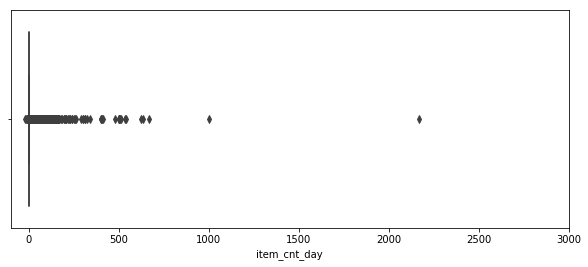

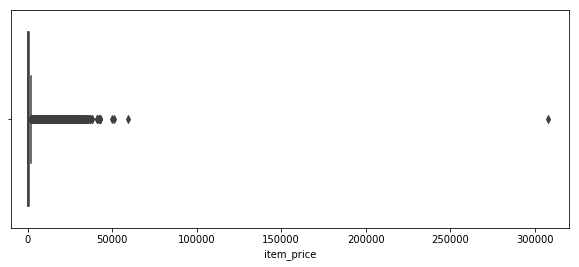

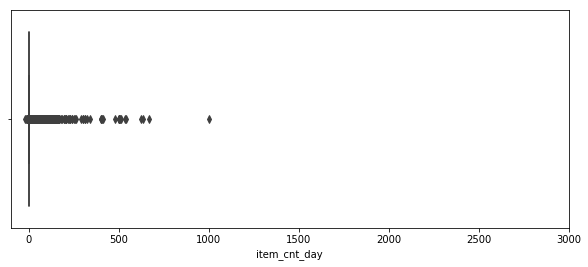

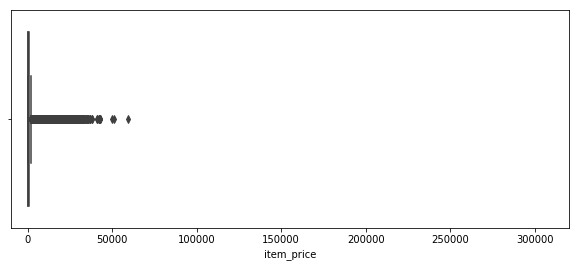

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x = sales_train['item_cnt_day'])

plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x = sales_train['item_price'])

sales_train = sales_train[sales_train['item_cnt_day'] <1001]
sales_train = sales_train[sales_train['item_price'] < 300000]
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x = sales_train['item_cnt_day'])

plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x = sales_train['item_price'])

2.there is a item with negative price, replace it with median
data_block_num = 4,
shop_id = 32,
item_id = 2973,
find the median price with such conditions

In [8]:
median = sales_train[(sales_train['date_block_num'] == 4) & (sales_train['shop_id'] == 32)\
                     & (sales_train['item_id'] == 2973) & (sales_train['item_price']>0)].item_price.median()
sales_train.loc[sales_train['item_price']<0,'item_price'] = median
print(median)

1874.0


# 1.2 baseline prediction
from coursera
" A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference."

In [9]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

groupby = sales_train.groupby(['item_id','shop_id','date_block_num']).agg({'item_cnt_day':'sum'})
groupby.columns = ['item_cnt_month']
groupby.reset_index(inplace=True)
matrix = matrix.merge(groupby, on = ['item_id','shop_id','date_block_num'], how = 'left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)
matrix.head()

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.shape

cols = ['date_block_num','shop_id','item_id']
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
print(matrix.head())

   date_block_num  shop_id  item_id  item_cnt_month
0               0        0       19             0.0
1               0        0       27             0.0
2               0        0       28             0.0
3               0        0       29             0.0
4               0        0       32             6.0


Simply put: Use October 2015 sales(number of items sold) as our predictions for sales of November 2015

In [10]:
sales_train_subset = sales_train[sales_train['date_block_num'] == 33]
sales_train_subset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
2882335,23.10.2015,33,45,13315,649.0,1.0,649.0
2882336,05.10.2015,33,45,13880,229.0,1.0,229.0
2882337,02.10.2015,33,45,13881,659.0,1.0,659.0
2882338,12.10.2015,33,45,13881,659.0,1.0,659.0
2882339,04.10.2015,33,45,13923,169.0,1.0,169.0


In [11]:
grouped = sales_train_subset[['shop_id','item_id','item_cnt_day']].groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum'}).reset_index()
grouped = grouped.rename(columns={'item_cnt_day' : 'item_cnt_month'})
grouped.head()

,shop_id,item_id,item_cnt_month
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0


In [12]:
test = pd.read_csv('../readonly/final_project_data/test.csv.gz')
test = pd.merge(test,grouped, on = ['shop_id','item_id'], how = 'left')
print(test.head())
#grouped.head()
test['item_cnt_month'] = test['item_cnt_month'].fillna(0).clip(0,20)
print(test.head())
test = test[['ID','item_cnt_month']]
submission = test.set_index('ID')
submission.to_csv('submission_baseline2.csv')

   ID  shop_id  item_id  item_cnt_month
0   0        5     5037             NaN
1   1        5     5320             NaN
2   2        5     5233             1.0
3   3        5     5232             NaN
4   4        5     5268             NaN
   ID  shop_id  item_id  item_cnt_month
0   0        5     5037             0.0
1   1        5     5320             0.0
2   2        5     5233             1.0
3   3        5     5232             0.0
4   4        5     5268             0.0


# 2. feature engineering
## 2.1 transform the category features
I want to modify the category names a little. After transformation, there are 15 types and various subtypes. Since there is not so much connections between neighbouring types, I choose to do one-hot encoding.

In [13]:
encoding_methods = ['label_encoding','onehot_encoding']
encoding_methods_index = 0

In [14]:
categories = pd.read_csv('../readonly/final_project_data/item_categories.csv')
lines1 = [26,27,28,29,30,31]
lines2 = [81,82]
for index in lines1:
    category_name = categories.loc[index,'item_category_name']
#    print(category_name)
    category_name = category_name.replace('Игры','Игры -')
#    print(category_name)
    categories.loc[index,'item_category_name'] = category_name
for index in lines2:
    category_name = categories.loc[index,'item_category_name']
#    print(category_name)
    category_name = category_name.replace('Чистые','Чистые -')
#    print(category_name)
    categories.loc[index,'item_category_name'] = category_name
category_name = categories.loc[32,'item_category_name']
#print(category_name)
category_name = category_name.replace('Карты оплаты','Карты оплаты -')
#print(category_name)
categories.loc[32,'item_category_name'] = category_name

In [15]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x:x[0].strip())
#categories['subtype'] = categories['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
categories = categories[['item_category_id','type']]
categories.head()

,item_category_id,type
0,0,PC
1,1,Аксессуары
2,2,Аксессуары
3,3,Аксессуары
4,4,Аксессуары


In [17]:
if(encoding_methods[encoding_methods_index] == 'label_encoding'):
    categories['type_code'] = LabelEncoder().fit_transform(categories['type'])
    #categories['subtype'] = LabelEncoder().fit_transform(categories['subtype'])
else:
    categories=pd.get_dummies(categories)
categories.head()

,item_category_id,type,type_code
0,0,PC,0
1,1,Аксессуары,1
2,2,Аксессуары,1
3,3,Аксессуары,1
4,4,Аксессуары,1


## 2.2 add city information in shops
there are 60 shops located in 31 cities, we can make use of such information by adding city_code features.

In [18]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

## 2.3 accumulate the monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [19]:
test.head()

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0


In [20]:
test = pd.read_csv('../readonly/final_project_data/test.csv.gz')
len(list(set(test.item_id) - set(test.item_id).intersection(set(sales_train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [21]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

groupby = sales_train.groupby(['item_id','shop_id','date_block_num']).agg({'item_cnt_day':'sum'})
groupby.columns = ['item_cnt_month']
groupby.reset_index(inplace=True)
matrix = matrix.merge(groupby, on = ['item_id','shop_id','date_block_num'], how = 'left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)
matrix.head()

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.shape

cols = ['date_block_num','shop_id','item_id']
matrix = pd.concat([matrix, test[['item_id','shop_id','date_block_num']]], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
print(matrix.head())

   date_block_num  shop_id  item_id  item_cnt_month
0               0        0       19             0.0
1               0        0       27             0.0
2               0        0       28             0.0
3               0        0       29             0.0
4               0        0       32             6.0


make sure there is no NAN in matrix before the next step

In [22]:
print(matrix['item_cnt_month'].isna().sum())
print(matrix['item_cnt_month'].isnull().sum())

0
0


## 2.4 merge related information into matrix

In [23]:
ts = time.time()
matrix = matrix.merge(items[['item_id','item_category_id']], on = ['item_id'], how = 'left')
matrix = matrix.merge(categories[['item_category_id','type_code']], on = ['item_category_id'], how = 'left')
matrix = matrix.merge(shops, on = ['shop_id'], how = 'left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
time.time() - ts

4.560785531997681

In [24]:
matrix.head()
#test.head()
#shops.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,type_code,city_code
0,0,0,19,0.0,40,7,29
1,0,0,27,0.0,19,5,29
2,0,0,28,0.0,30,5,29
3,0,0,29,0.0,23,5,29
4,0,0,32,6.0,40,7,29


## 2.5 lag operation

In [25]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

### 2.5.1 lag features for monthly sale 

In [26]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

30.34631371498108

In [27]:
#matrix.tail()
#print(matrix.loc[(matrix['date_block_num'] == 0)&(matrix['shop_id'] == 0)].count())
#print(matrix.loc[matrix['date_block_num'] == 1,'item_cnt_month_lag_1'].head())
#print(matrix.iloc[365175])

### 2.5.2 mean value of monthly sales and its lag features

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

36.87462115287781

In [29]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 17 columns):
date_block_num              int8
shop_id                     int8
item_id                     int16
item_cnt_month              float16
item_category_id            int8
type_code                   int8
city_code                   int8
item_cnt_month_lag_1        float16
item_cnt_month_lag_2        float16
item_cnt_month_lag_3        float16
item_cnt_month_lag_6        float16
item_cnt_month_lag_12       float16
date_avg_item_cnt_lag_1     float16
date_avg_item_cnt_lag_2     float16
date_avg_item_cnt_lag_3     float16
date_avg_item_cnt_lag_6     float16
date_avg_item_cnt_lag_12    float16
dtypes: float16(11), int16(1), int8(5)
memory usage: 392.7 MB


### 2.5.3 mean value of monthly sales(items) and its lag features

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

39.66010785102844

In [31]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 22 columns):
date_block_num                   int8
shop_id                          int8
item_id                          int16
item_cnt_month                   float16
item_category_id                 int8
type_code                        int8
city_code                        int8
item_cnt_month_lag_1             float16
item_cnt_month_lag_2             float16
item_cnt_month_lag_3             float16
item_cnt_month_lag_6             float16
item_cnt_month_lag_12            float16
date_avg_item_cnt_lag_1          float16
date_avg_item_cnt_lag_2          float16
date_avg_item_cnt_lag_3          float16
date_avg_item_cnt_lag_6          float16
date_avg_item_cnt_lag_12         float16
date_item_avg_item_cnt_lag_1     float16
date_item_avg_item_cnt_lag_2     float16
date_item_avg_item_cnt_lag_3     float16
date_item_avg_item_cnt_lag_6     float16
date_item_avg_item_cnt_lag_12    float16


### 2.5.4 mean value of monthly sales(shop) and its lag features

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

38.822147369384766

In [33]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 27 columns):
date_block_num                   int8
shop_id                          int8
item_id                          int16
item_cnt_month                   float16
item_category_id                 int8
type_code                        int8
city_code                        int8
item_cnt_month_lag_1             float16
item_cnt_month_lag_2             float16
item_cnt_month_lag_3             float16
item_cnt_month_lag_6             float16
item_cnt_month_lag_12            float16
date_avg_item_cnt_lag_1          float16
date_avg_item_cnt_lag_2          float16
date_avg_item_cnt_lag_3          float16
date_avg_item_cnt_lag_6          float16
date_avg_item_cnt_lag_12         float16
date_item_avg_item_cnt_lag_1     float16
date_item_avg_item_cnt_lag_2     float16
date_item_avg_item_cnt_lag_3     float16
date_item_avg_item_cnt_lag_6     float16
date_item_avg_item_cnt_lag_12    float16


### 2.5.5 mean value of monthly sales(cat) and its lag features

In [34]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

41.57666826248169

In [35]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 32 columns):
date_block_num                   int8
shop_id                          int8
item_id                          int16
item_cnt_month                   float16
item_category_id                 int8
type_code                        int8
city_code                        int8
item_cnt_month_lag_1             float16
item_cnt_month_lag_2             float16
item_cnt_month_lag_3             float16
item_cnt_month_lag_6             float16
item_cnt_month_lag_12            float16
date_avg_item_cnt_lag_1          float16
date_avg_item_cnt_lag_2          float16
date_avg_item_cnt_lag_3          float16
date_avg_item_cnt_lag_6          float16
date_avg_item_cnt_lag_12         float16
date_item_avg_item_cnt_lag_1     float16
date_item_avg_item_cnt_lag_2     float16
date_item_avg_item_cnt_lag_3     float16
date_item_avg_item_cnt_lag_6     float16
date_item_avg_item_cnt_lag_12    float16


### 2.5.6 mean value of monthly sales(type) and its lag features

In [36]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

44.775643825531006

In [37]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 37 columns):
date_block_num                   int8
shop_id                          int8
item_id                          int16
item_cnt_month                   float16
item_category_id                 int8
type_code                        int8
city_code                        int8
item_cnt_month_lag_1             float16
item_cnt_month_lag_2             float16
item_cnt_month_lag_3             float16
item_cnt_month_lag_6             float16
item_cnt_month_lag_12            float16
date_avg_item_cnt_lag_1          float16
date_avg_item_cnt_lag_2          float16
date_avg_item_cnt_lag_3          float16
date_avg_item_cnt_lag_6          float16
date_avg_item_cnt_lag_12         float16
date_item_avg_item_cnt_lag_1     float16
date_item_avg_item_cnt_lag_2     float16
date_item_avg_item_cnt_lag_3     float16
date_item_avg_item_cnt_lag_6     float16
date_item_avg_item_cnt_lag_12    float16


### 2.5.7 mean value of monthly sales(city) and its lag features

In [38]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num',  'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

46.27891659736633

In [39]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 42 columns):
date_block_num                   int8
shop_id                          int8
item_id                          int16
item_cnt_month                   float16
item_category_id                 int8
type_code                        int8
city_code                        int8
item_cnt_month_lag_1             float16
item_cnt_month_lag_2             float16
item_cnt_month_lag_3             float16
item_cnt_month_lag_6             float16
item_cnt_month_lag_12            float16
date_avg_item_cnt_lag_1          float16
date_avg_item_cnt_lag_2          float16
date_avg_item_cnt_lag_3          float16
date_avg_item_cnt_lag_6          float16
date_avg_item_cnt_lag_12         float16
date_item_avg_item_cnt_lag_1     float16
date_item_avg_item_cnt_lag_2     float16
date_item_avg_item_cnt_lag_3     float16
date_item_avg_item_cnt_lag_6     float16
date_item_avg_item_cnt_lag_12    float16


### 2.5.8 mean value of monthly sales(cat,city) and its lag features

In [40]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id','city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id','city_code'], how='left')
matrix['date_cat_city_avg_item_cnt'] = matrix['date_cat_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_cat_city_avg_item_cnt')
matrix.drop(['date_cat_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

53.50985789299011

In [41]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 47 columns):
date_block_num                       int8
shop_id                              int8
item_id                              int16
item_cnt_month                       float16
item_category_id                     int8
type_code                            int8
city_code                            int8
item_cnt_month_lag_1                 float16
item_cnt_month_lag_2                 float16
item_cnt_month_lag_3                 float16
item_cnt_month_lag_6                 float16
item_cnt_month_lag_12                float16
date_avg_item_cnt_lag_1              float16
date_avg_item_cnt_lag_2              float16
date_avg_item_cnt_lag_3              float16
date_avg_item_cnt_lag_6              float16
date_avg_item_cnt_lag_12             float16
date_item_avg_item_cnt_lag_1         float16
date_item_avg_item_cnt_lag_2         float16
date_item_avg_item_cnt_lag_3         float16
da

### 2.5.9 mean value of monthly sales(type,city) and its lag features

In [42]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code','city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code','city_code'], how='left')
matrix['date_type_city_avg_item_cnt'] = matrix['date_type_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_type_city_avg_item_cnt')
matrix.drop(['date_type_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

54.55735635757446

In [43]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 52 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
item_cnt_month                        float16
item_category_id                      int8
type_code                             int8
city_code                             int8
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2                  float16
item_cnt_month_lag_3                  float16
item_cnt_month_lag_6                  float16
item_cnt_month_lag_12                 float16
date_avg_item_cnt_lag_1               float16
date_avg_item_cnt_lag_2               float16
date_avg_item_cnt_lag_3               float16
date_avg_item_cnt_lag_6               float16
date_avg_item_cnt_lag_12              float16
date_item_avg_item_cnt_lag_1          float16
date_item_avg_item_cnt_lag_2          float16
date_item_avg_item_cnt_lag_3

### 2.5.10 mean value of monthly sales(type,shop) and its lag features

In [44]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code','shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code','shop_id'], how='left')
matrix['date_type_shop_avg_item_cnt'] = matrix['date_type_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_type_shop_avg_item_cnt')
matrix.drop(['date_type_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

55.10264801979065

In [45]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 57 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
item_cnt_month                        float16
item_category_id                      int8
type_code                             int8
city_code                             int8
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2                  float16
item_cnt_month_lag_3                  float16
item_cnt_month_lag_6                  float16
item_cnt_month_lag_12                 float16
date_avg_item_cnt_lag_1               float16
date_avg_item_cnt_lag_2               float16
date_avg_item_cnt_lag_3               float16
date_avg_item_cnt_lag_6               float16
date_avg_item_cnt_lag_12              float16
date_item_avg_item_cnt_lag_1          float16
date_item_avg_item_cnt_lag_2          float16
date_item_avg_item_cnt_lag_3

## 2.6 trend features

Price trend

In [46]:
ts = time.time()
group = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6,12]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

661.6136984825134

In [47]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 58 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
item_cnt_month                        float16
item_category_id                      int8
type_code                             int8
city_code                             int8
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2                  float16
item_cnt_month_lag_3                  float16
item_cnt_month_lag_6                  float16
item_cnt_month_lag_12                 float16
date_avg_item_cnt_lag_1               float16
date_avg_item_cnt_lag_2               float16
date_avg_item_cnt_lag_3               float16
date_avg_item_cnt_lag_6               float16
date_avg_item_cnt_lag_12              float16
date_item_avg_item_cnt_lag_1          float16
date_item_avg_item_cnt_lag_2          float16
date_item_avg_item_cnt_lag_3

Last month shop revenue trend

In [48]:
ts = time.time()
group = sales_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

30.622531414031982

In [49]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 59 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
item_cnt_month                        float16
item_category_id                      int8
type_code                             int8
city_code                             int8
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2                  float16
item_cnt_month_lag_3                  float16
item_cnt_month_lag_6                  float16
item_cnt_month_lag_12                 float16
date_avg_item_cnt_lag_1               float16
date_avg_item_cnt_lag_2               float16
date_avg_item_cnt_lag_3               float16
date_avg_item_cnt_lag_6               float16
date_avg_item_cnt_lag_12              float16
date_item_avg_item_cnt_lag_1          float16
date_item_avg_item_cnt_lag_2          float16
date_item_avg_item_cnt_lag_3

## 2.7 Special features¶

In [50]:
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.

In [51]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

723.9734854698181

In [52]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 62 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
item_cnt_month                        float16
item_category_id                      int8
type_code                             int8
city_code                             int8
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2                  float16
item_cnt_month_lag_3                  float16
item_cnt_month_lag_6                  float16
item_cnt_month_lag_12                 float16
date_avg_item_cnt_lag_1               float16
date_avg_item_cnt_lag_2               float16
date_avg_item_cnt_lag_3               float16
date_avg_item_cnt_lag_6               float16
date_avg_item_cnt_lag_12              float16
date_item_avg_item_cnt_lag_1          float16
date_item_avg_item_cnt_lag_2          float16
date_item_avg_item_cnt_lag_3

Months since the first sale for each shop/item pair and for item only.

In [53]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.6329493522644043

## 2.8 Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set). 

In [54]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

2.4995715618133545

In [55]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

6.853430271148682

In [56]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_category_id', 'type_code', 'city_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_avg_item_cnt_lag_2', 'date_avg_item_cnt_lag_3',
       'date_avg_item_cnt_lag_6', 'date_avg_item_cnt_lag_12',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6',
       'date_cat_avg_item_cnt_lag_12', 'date_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_

In [57]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 64 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
item_cnt_month                        float16
item_category_id                      int8
type_code                             int8
city_code                             int8
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2                  float16
item_cnt_month_lag_3                  float16
item_cnt_month_lag_6                  float16
item_cnt_month_lag_12                 float16
date_avg_item_cnt_lag_1               float16
date_avg_item_cnt_lag_2               float16
date_avg_item_cnt_lag_3               float16
date_avg_item_cnt_lag_6               float16
date_avg_item_cnt_lag_12              float16
date_item_avg_item_cnt_lag_1          float16
date_item_avg_item_cnt_lag_2          float16
date_item_avg_item_cnt_

In [58]:
matrix.to_pickle('data.pkl')

NameError: name 'cats' is not defined

In [59]:
del matrix
del cache
del group
del items
del shops
del categories
del sales_train
# leave test for submission
gc.collect()

NameError: name 'matrix' is not defined

# 3.xgb

In [3]:
data = pd.read_pickle('data.pkl')

In [4]:
# selecte features

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
del data
gc.collect();


In [7]:
ts = time.time()
from xgboost import XGBRegressor
from xgboost import plot_importance
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

D:\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


MemoryError: 

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
plot_features(model, (10,14))